In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow.keras import models, layers


In [3]:
real_path = "/kaggle/input/socofing/SOCOFing/Real"
altered_medium_path ="/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium"
    


In [4]:
# 🖼️ Step 3: Load Data Function
def load_data(real_dir, altered_dir, image_size):
    x = []
    y = []
    img_width, img_height = image_size

    # Real images → Label 1
    for filename in os.listdir(real_dir):
        path = os.path.join(real_dir, filename)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0
        x.append(img)
        y.append(1)

    # Altered images → Label 0
    for filename in os.listdir(altered_dir):
        path = os.path.join(altered_dir, filename)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0
        x.append(img)
        y.append(0)

    x = np.array(x)
    y = np.array(y)
    x, y = shuffle(x, y, random_state=42)

    return x, y

In [5]:
def split_data(x, y, test_size=0.2):
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=test_size, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test

# ⚙️ Step 5: Load and Split

In [6]:
IMG_SIZE = (64, 64)

x, y = load_data(real_path, altered_medium_path, IMG_SIZE)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(x, y, test_size=0.2)


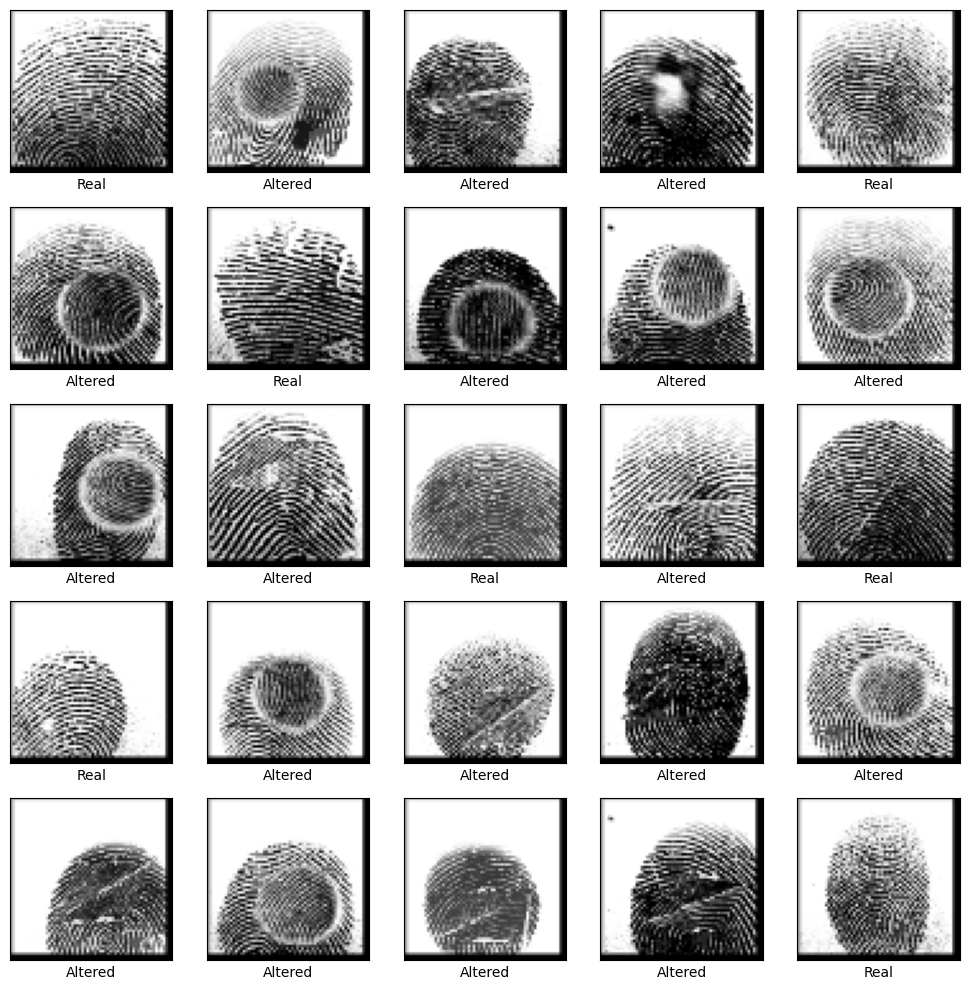

In [7]:
# 🎨 Show Sample Images
class_names = ['Altered', 'Real']
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([]), plt.yticks([]), plt.grid(False)
    plt.imshow(x_train[i])
    label = "Real" if y_train[i] == 1 else "Altered"
    plt.xlabel(label)
plt.tight_layout()
plt.show()


In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),  # Replacing Flatten with GlobalAveragePooling
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,545 (236.50 KB)

 Trainable params: 60,545 (236.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 🚀 Step 9: Train the Model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(x_val, y_val)
)

Epoch 1/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.7534 - loss: 0.5379 - val_accuracy: 0.8791 - val_loss: 0.3434
Epoch 2/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 50s 87ms/step - accuracy: 0.8717 - loss: 0.3329 - val_accuracy: 0.9133 - val_loss: 0.2274
Epoch 3/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 50s 87ms/step - accuracy: 0.9021 - loss: 0.2414 - val_accuracy: 0.9315 - val_loss: 0.1863
Epoch 4/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.9247 - loss: 0.1910 - val_accuracy: 0.9528 - val_loss: 0.1350
Epoch 5/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 50s 87ms/step - accuracy: 0.9453 - loss: 0.1420 - val_accuracy: 0.9580 - val_loss: 0.1197
Epoch 6/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.9541 - loss: 0.1209 - val_accuracy: 0.9610 - val_loss: 0.1016
Epoch 7/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9608 - loss: 0.1026 - val_accuracy: 0.9753 - val_loss: 0.0690
Epoch 8/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 50s 87ms/step - accuracy: 0.9667 - loss: 0.0901 - 

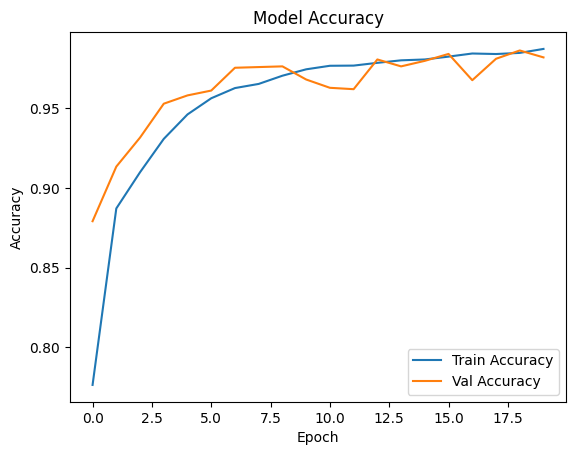

In [11]:
# 📈 Step 10: Training Curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


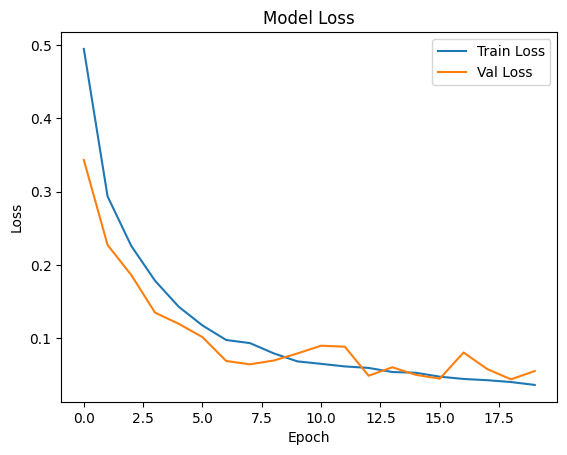

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [13]:
# 🧪 Step 11: Evaluate on Test Set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"🧪 Test Accuracy: {test_acc * 100:.2f}%")

73/73 - 2s - 23ms/step - accuracy: 0.9805 - loss: 0.0576
🧪 Test Accuracy: 98.05%


In [14]:
# 🔍 Step 12: Classification Metrics
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Altered', 'Real']))



📊 Classification Report:
              precision    recall  f1-score   support

     Altered       0.99      0.98      0.99      1724
        Real       0.95      0.98      0.96       583

    accuracy                           0.98      2307
   macro avg       0.97      0.98      0.97      2307
weighted avg       0.98      0.98      0.98      2307



In [16]:
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

🧾 Confusion Matrix:
[[1692   32]
 [  13  570]]


In [17]:
model.save("fingerprint_spoof_model.h5")


**Split dataset**

Function for splitting dataset as train, test and validation.

**Load data**

**Load and split data**